In [7]:
import os

from itertools import product

import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
import cmocean

import cartopy
import cartopy.crs as ccrs


import xpersist as xp
cache_dir = '/glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields'
if (os.path.isdir(cache_dir)):
    xp.settings['cache_dir'] = cache_dir
os.makedirs(cache_dir, exist_ok=True)

os.environ['CESMDATAROOT'] = '/glade/scratch/mclong/inputdata'
import pop_tools

import climo_utils as cu
import utils

import regrid_tools

In [2]:
ds = xr.open_dataset('/glade/p/cgd/oce/projects/cesm2-marbl/satellite-pic/A20021852019334.L3m_CU_PIC_pic_9km.nc')
pic = ds.pic.where(
    (ds.pic.valid_min <= ds.pic) & (ds.pic <= ds.pic.valid_max)
)
ds['lat'] = ds.lat[::-1]
ds.pic.data = ds.pic.data[::-1, :]
ds.pic

<xarray.DataArray 'pic' (lat: 2160, lon: 4320)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * lat      (lat) float32 -89.96 -89.88 -89.79 -89.71 ... 89.79 89.88 89.96
  * lon      (lon) float32 -180.0 -179.9 -179.8 -179.7 ... 179.8 179.9 180.0
Attributes:
    long_name:      Calcite Concentration, Balch and Gordon
    units:          mol m^-3
    valid_min:      -32500
    valid_max:      30000
    reference:      Balch, W.M., Gordon, H.R., Bowler, B.C., Drapeau, D.T., a...
    display_scale:  log
    display_min:    1e-05
    display_max:    0.05

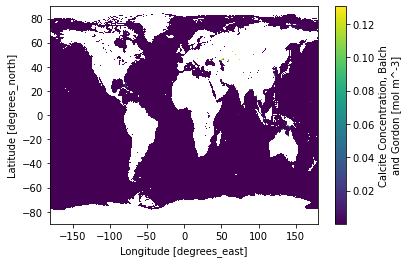

In [3]:
ds.pic.plot()

In [4]:
dst_grid = regrid_tools.grid('POP_gx1v7', clobber=False)
src_grid = regrid_tools.grid('latlon_9km', nx=4320, ny=2160, lon0=-180.)

regridder = regrid_tools.regridder(src_grid, dst_grid, 'conserve', clobber=False)
dso_model = regridder.regrid(ds[['pic']], renormalize=True, apply_mask=False,).rename({'lat': 'nlat', 'lon': 'nlon'})
dso_model   

exists: /glade/work/mclong/adhoc-regridding/POP_gx1v7.nc
exists: /glade/work/mclong/adhoc-regridding/latlon_9km.nc
source grid dims: (2160, 4320)
destination grid dims: (384, 320)


<xarray.Dataset>
Dimensions:  (nlat: 384, nlon: 320)
Dimensions without coordinates: nlat, nlon
Data variables:
    pic      (nlat, nlon) float64 nan nan nan nan nan ... nan nan nan nan nan
Attributes: (12/63)
    product_name:                      A20021852019334.L3m_CU_PIC_pic_9km.nc
    instrument:                        MODIS
    title:                             MODISA Level-3 Standard Mapped Image
    project:                           Ocean Biology Processing Group (NASA/G...
    platform:                          Aqua
    temporal_range:                    17-year
    ...                                ...
    identifier_product_doi:            10.5067/AQUA/MODIS/L3M/PIC/2018
    keywords:                          Earth Science > Oceans > Ocean Chemist...
    keywords_vocabulary:               NASA Global Change Master Directory (G...
    data_bins:                         5729919
    data_minimum:                      1.1995433e-05
    data_maximum:                      0.13053401

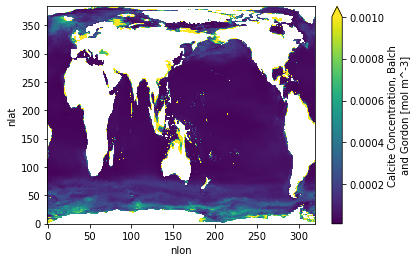

In [5]:
dso_model.pic.plot(vmax=0.001)

In [9]:
nmolcm2s_to_molm2yr = 1e-9 * 1e4 * 86400 * 365.
nmols_to_PgCyr = 1e-9 * 12. * 1e-15 * 86400 * 365.

time_slice = slice("1990-01-15", "2015-01-15")
varlist = [
    'spCaCO3', 
]
postprocess = {v: None for v in varlist}
postprocess['spCaCO3'] = lambda ds: ds.isel(z_t_150m=0)

ds_list = []
for variable in varlist:
    xp_func = xp.persist_ds(cu.read_CESM_var, name=f'Alk-cycle-{variable}', trust_cache=True)    
    ds_list.append(xp_func(
        time_slice, 
        variable, 
        mean_dims=['member_id', 'time'], 
        postprocess=postprocess[variable]
    ))

ds = xr.merge(ds_list)    
ds


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream'


/glade/work/mclong/miniconda3/envs/cesm2-marbl/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


writing cache file: /glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields/Alk-cycle-spCaCO3.nc


<xarray.Dataset>
Dimensions:      (nlat: 384, nlon: 320, z_t: 60)
Coordinates:
  * z_t          (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
    TLONG        (nlat, nlon) float64 320.6 321.7 322.8 ... 318.9 319.4 319.8
    TLAT         (nlat, nlon) float64 -79.22 -79.22 -79.22 ... 72.2 72.19 72.19
    z_t_150m     float32 500.0
    ULONG        (nlat, nlon) float64 321.1 322.3 323.4 ... 319.2 319.6 320.0
    ULAT         (nlat, nlon) float64 -78.95 -78.95 -78.95 ... 72.42 72.41 72.41
Dimensions without coordinates: nlat, nlon
Data variables:
    REGION_MASK  (nlat, nlon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    dz           (z_t) float32 1e+03 1e+03 1e+03 ... 2.499e+04 2.5e+04 2.5e+04
    TAREA        (nlat, nlon) float64 1.125e+13 1.125e+13 ... 7.432e+12
    KMT          (nlat, nlon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    spCaCO3      (nlat, nlon) float32 nan nan nan nan nan ... nan nan nan nan